# NFW Host + Subhalo Lens — Amplification Factor

This notebook demonstrates gravitational lensing by a **composite NFW lens system**
consisting of an elliptical host halo, an external shear component, and an optional
NFW subhalo using FIONA's `FresnelNUFFT3` solver.

The main visualisation produced is:

- **$|F(\omega)|$ vs $\omega$ curves** — the amplification factor as a function of
  dimensionless frequency for a host-only lens compared with host + subhalo lenses
  at CDM-motivated concentrations ($c_{\rm CDM}$, $2c_{\rm CDM}$, $3c_{\rm CDM}$).

Three separate plots are generated for subhalo masses
$M_{\rm sub} = 10^9\,M_\odot$, $10^{10}\,M_\odot$, and $10^{11}\,M_\odot$.

## 1. Environment Setup

FIONA caches 2-D Gauss–Legendre quadrature grids on disk.  
Set `FIONA_GL2D_DIR` to a writable directory **before** importing FIONA so the cache is
found (or created) correctly.  
Adjust the path and thread counts to match your hardware.

Threading is disabled for NumPy/MKL/OpenBLAS so that FIONA's own parallelism
(via `nufft_workers`) has exclusive access to CPU cores.

In [1]:
%matplotlib inline

import os
os.environ["FIONA_GL2D_DIR"] = os.environ.get(
    "FIONA_GL2D_DIR",
    "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"
)
os.environ["FIONA_GL2D_STRICT"] = os.environ.get("FIONA_GL2D_STRICT", "0")
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "112")

# Disable internal threading so FIONA workers have exclusive CPU access
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

## 2. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from fiona import (
    NFW_ELLIPSE_POTENTIAL,
    Shear,
    set_num_threads,
    FresnelNUFFT3,
)
from fiona.utils import spline_fit_eval

# Use up to 112 threads (adjust to your hardware)
set_num_threads(112)

## 3. Composite Lens

`CompositeLens` sums the lensing potentials of an arbitrary number of individual
lens components.  This makes it straightforward to combine a host halo, a subhalo,
and an external shear into a single lens object that FIONA can evaluate.

In [3]:
class CompositeLens:
    """Sum the lensing potentials of multiple individual lens components."""

    def __init__(self, *lenses):
        self.lenses = lenses

    def psi_xy(self, x1, x2):
        psi = 0.0
        for L in self.lenses:
            psi = psi + L.psi_xy(x1, x2)
        return psi

## 4. NFW Parameter Conversion

FIONA's `NFW_ELLIPSE_POTENTIAL` requires the NFW scale radius $R_s$ (arcsec) and
the deflection angle at the scale radius $\alpha_{R_s}$ (arcsec).  
The helper below converts the physical halo mass $M_{200}$ and concentration $c_{200}$
to these lenstronomy-style angular parameters using `LensCosmo`.

In [4]:
def nfw_Mc_to_lenstronomy_Rs_alphaRs(M200, c200, z_lens, z_source, cosmo=None):
    """Convert NFW mass and concentration to lenstronomy angular parameters.

    Parameters
    ----------
    M200 : float
        Halo mass within $r_{200}$ in solar masses.
    c200 : float
        Concentration parameter $c_{200}$.
    z_lens : float
        Lens redshift.
    z_source : float
        Source redshift.
    cosmo : astropy.cosmology, optional
        Cosmology instance.  Defaults to a flat ΛCDM with H0=70, Ωm=0.3.

    Returns
    -------
    Rs_arcsec : float
        NFW scale radius in arcseconds.
    alpha_Rs_arcsec : float
        Deflection angle at the scale radius in arcseconds.
    """
    if cosmo is None:
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3, Ob0=0.048)
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    Rs_arcsec, alpha_Rs_arcsec = lens_cosmo.nfw_physical2angle(M=M200, c=c200)
    return float(Rs_arcsec), float(alpha_Rs_arcsec)

## 5. Lens Builders

Two convenience functions construct ready-to-use `CompositeLens` objects:

- **`build_host_lens`** — elliptical NFW host halo + external shear.
- **`build_host_plus_subhalo_lens`** — same host + an additional NFW subhalo
  placed at `sub_center` + external shear.

In [5]:
def build_host_lens(
    M200_host=1e13,
    c200_host=30.0,
    z_lens=0.5,
    z_source=1.5,
    host_e1=0.2,
    host_e2=0.0,
    shear_g1=0.03,
    shear_g2=0.01,
):
    """Build a host-only NFW lens with external shear.

    Parameters
    ----------
    M200_host : float
        Host halo mass in solar masses.
    c200_host : float
        Host halo concentration.
    z_lens, z_source : float
        Lens and source redshifts.
    host_e1, host_e2 : float
        Ellipticity components of the host halo.
    shear_g1, shear_g2 : float
        External shear components.

    Returns
    -------
    CompositeLens
        Host NFW halo + external shear.
    """
    Rs_h, alpha_h = nfw_Mc_to_lenstronomy_Rs_alphaRs(M200_host, c200_host, z_lens, z_source)
    host = NFW_ELLIPSE_POTENTIAL(
        Rs=Rs_h,
        alpha_Rs=alpha_h,
        e1=host_e1,
        e2=host_e2,
        center_x=0.0,
        center_y=0.0,
    )
    shear = Shear(gamma1=shear_g1, gamma2=shear_g2, ra_0=0.0, dec_0=0.0)
    return CompositeLens(host, shear)


def build_host_plus_subhalo_lens(
    M200_host=1e13,
    c200_host=30.0,
    M200_sub=1e10,
    c200_sub=30.0,
    z_lens=0.5,
    z_source=1.5,
    host_e1=0.2,
    host_e2=0.0,
    sub_e1=0.0,
    sub_e2=0.0,
    sub_center=(0.3, 0.0),
    shear_g1=0.03,
    shear_g2=0.01,
):
    """Build a host NFW lens plus a subhalo NFW lens with external shear.

    Parameters
    ----------
    M200_host, c200_host : float
        Host halo mass (solar masses) and concentration.
    M200_sub, c200_sub : float
        Subhalo mass (solar masses) and concentration.
    z_lens, z_source : float
        Lens and source redshifts.
    host_e1, host_e2 : float
        Ellipticity components of the host halo.
    sub_e1, sub_e2 : float
        Ellipticity components of the subhalo.
    sub_center : tuple of float
        (x, y) position of the subhalo centre in arcseconds.
    shear_g1, shear_g2 : float
        External shear components.

    Returns
    -------
    CompositeLens
        Host NFW halo + subhalo NFW halo + external shear.
    """
    Rs_h, alpha_h = nfw_Mc_to_lenstronomy_Rs_alphaRs(M200_host, c200_host, z_lens, z_source)
    Rs_s, alpha_s = nfw_Mc_to_lenstronomy_Rs_alphaRs(M200_sub, c200_sub, z_lens, z_source)

    host = NFW_ELLIPSE_POTENTIAL(
        Rs=Rs_h,
        alpha_Rs=alpha_h,
        e1=host_e1,
        e2=host_e2,
        center_x=0.0,
        center_y=0.0,
    )

    sub = NFW_ELLIPSE_POTENTIAL(
        Rs=Rs_s,
        alpha_Rs=alpha_s,
        e1=sub_e1,
        e2=sub_e2,
        center_x=sub_center[0],
        center_y=sub_center[1],
    )

    shear = Shear(gamma1=shear_g1, gamma2=shear_g2, ra_0=0.0, dec_0=0.0)
    return CompositeLens(host, sub, shear)

## 6. Utility Functions

### 6.1 Finite-difference deflection angles

`alpha_xy_fd` computes the lens deflection angles $(\alpha_1, \alpha_2)$ from the
lensing potential using a symmetric finite-difference stencil with step size `eps`.

In [6]:
def alpha_xy_fd(lens, x1, x2, eps=1e-4):
    """Compute deflection angles via symmetric finite differences.

    Parameters
    ----------
    lens : object with psi_xy method
        The lens whose potential is differentiated.
    x1, x2 : float
        Image-plane coordinates (arcseconds).
    eps : float, optional
        Finite-difference step size.

    Returns
    -------
    alpha1, alpha2 : float
        Deflection angle components.
    """
    psi_xp = lens.psi_xy(x1 + eps, x2)
    psi_xm = lens.psi_xy(x1 - eps, x2)
    psi_yp = lens.psi_xy(x1, x2 + eps)
    psi_ym = lens.psi_xy(x1, x2 - eps)
    return (psi_xp - psi_xm) / (2 * eps), (psi_yp - psi_ym) / (2 * eps)

### 6.2 CDM concentration–mass relation

A simple power-law approximation to the CDM concentration–mass relation:
$$c_{\rm CDM}(M) = c_0 \left(\frac{M}{m_0}\right)^{-\beta}$$

Higher-concentration ($2c$, $3c$) cases are also explored to bracket the
uncertainty in the subhalo concentration.

In [7]:
def cdm_concentration(M, c0=20.0, m0=1e10, beta=0.1):
    """CDM concentration–mass relation (power-law approximation).

    Parameters
    ----------
    M : float or array
        Halo mass in solar masses.
    c0 : float
        Normalisation concentration at mass m0.
    m0 : float
        Pivot mass in solar masses.
    beta : float
        Slope of the concentration–mass relation.

    Returns
    -------
    float or array
        Concentration $c_{\rm CDM}$.
    """
    return c0 * (M / m0) ** (-beta)

### 6.3 Colour palette helper

`pastel_gradient` returns `n` colours sampled at equal intervals from a matplotlib
colourmap, useful for visually distinguishing multiple subhalo concentration values.

In [8]:
def pastel_gradient(n=3, cmap_name="Blues", start=0.35, end=0.85):
    """Sample n colours from a matplotlib colourmap.

    Parameters
    ----------
    n : int
        Number of colours to return.
    cmap_name : str
        Name of the matplotlib colourmap.
    start, end : float
        Colourmap range to sample from (0–1).

    Returns
    -------
    list of RGBA tuples
    """
    cmap = plt.get_cmap(cmap_name)
    return [cmap(v) for v in np.linspace(start, end, n)]

## 7. Main Plotting Function

`plot_host_vs_subhalo_Fw_overplots` is the top-level routine that:

1. Builds a host-only lens and computes its amplification factor $|F(\omega)|$.
2. For each subhalo mass in `M_sub_list`, computes $|F(\omega)|$ for three
   concentration values ($c_{\rm CDM}$, $2c_{\rm CDM}$, $3c_{\rm CDM}$).
3. Plots host and host+subhalo curves on the same axes for visual comparison.

The source position is pinned to the lensed image of the subhalo centre using the
lens equation evaluated at the subhalo position, ensuring a fair comparison across
different subhalo masses.

Key parameters controlling the NUFFT computation:

| Parameter | Description |
|---|---|
| `gl_nodes_per_dim` | Gauss–Legendre grid size per dimension |
| `nufft_tol` | NUFFT accuracy tolerance |
| `nufft_workers` | Number of parallel workers |
| `window_potential` | Apply a Hann window to the lensing potential |
| `use_tail_correction` | Add an analytic tail correction beyond the GL grid |

In [9]:
def plot_host_vs_subhalo_Fw_overplots(
    w_grid=np.linspace(0.1, 10.0, 560),
    M200_host=1e13,
    c200_host=30.0,
    M_sub_list=(1e10),
    z_lens=0.5,
    z_source=1.5,
    host_e1=0.2,
    host_e2=0.0,
    sub_e1=0.0,
    sub_e2=0.0,
    sub_center=(0.3, 0.0),
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=4000,
    min_physical_radius=10.0,
    nufft_tol=1e-9,
    auto_R_from_gl_nodes=True,
    use_tail_correction=True,
    window_potential=True,
    window_radius_fraction=0.75,
    window_u=True,
    window_u_width=0.02,
    coordinate_system="cartesian",
    numexpr_nthreads=1,        # Disable internal threading
    parallel_frequencies=True, # Enable multiprocessing
    nufft_workers=112,         # Create 112 independent workers
    nufft_nthreads=1,          # Each worker uses 1 thread
    nufft_tile_max_points=4000**2,
    nufft_tile_autotune=True,
    nufft_tile_candidates=(500000, 1000000, 2000000, 4000000, 6000000, 8000000),
    spline=False,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=14,
    c0=20.0,
    m0=1e10,
    beta=0.1,
):
    """Compute and plot |F(ω)| for a host lens vs host+subhalo lenses.

    For each subhalo mass in M_sub_list, three subhalo concentration values are
    explored: c_CDM, 2*c_CDM, and 3*c_CDM, where c_CDM is determined by the
    power-law concentration–mass relation.

    The source position is fixed at the image of the subhalo centre under the
    reference (middle-mass) lens, so comparisons are made at the same source
    position across all curves.

    Parameters
    ----------
    w_grid : array-like
        Dimensionless frequency grid ω at which to evaluate F.
    M200_host : float
        Host halo mass in solar masses.
    c200_host : float
        Host halo concentration.
    M_sub_list : sequence of float
        Subhalo masses in solar masses.  One panel is created per mass.
    z_lens, z_source : float
        Lens and source redshifts.
    host_e1, host_e2 : float
        Host halo ellipticity components.
    sub_e1, sub_e2 : float
        Subhalo ellipticity components.
    sub_center : tuple of float
        (x, y) image-plane position of the subhalo centre (arcsec).
    shear_g1, shear_g2 : float
        External shear components.
    gl_nodes_per_dim : int
        Number of Gauss–Legendre nodes per dimension.
    min_physical_radius : float
        Minimum physical integration radius (same units as the GL grid).
    nufft_tol : float
        NUFFT accuracy tolerance.
    auto_R_from_gl_nodes : bool
        Automatically set the outer GL radius from gl_nodes_per_dim.
    use_tail_correction : bool
        Add an analytic correction beyond the GL grid boundary.
    window_potential : bool
        Apply a windowing function to the lensing potential.
    window_radius_fraction : float
        Fraction of the GL radius at which the window starts rolling off.
    window_u : bool
        Apply a window in the u (frequency) domain.
    window_u_width : float
        Width of the u-domain window roll-off.
    coordinate_system : str
        Coordinate system used by the NUFFT ('cartesian' or 'polar').
    numexpr_nthreads : int
        Number of threads for numexpr (set to 1 to avoid contention).
    parallel_frequencies : bool
        Evaluate frequencies in parallel using multiprocessing.
    nufft_workers : int
        Number of independent NUFFT worker processes.
    nufft_nthreads : int
        Threads per NUFFT worker (usually 1 when workers > 1).
    nufft_tile_max_points : int
        Maximum number of points per NUFFT tile.
    nufft_tile_autotune : bool
        Automatically tune the tile size.
    nufft_tile_candidates : tuple of int
        Candidate tile sizes considered during autotuning.
    spline : bool
        If True, fit a spline to the computed curves before plotting.
    spline_method : str
        Spline fitting method passed to spline_fit_eval.
    spline_s : float or None
        Smoothing factor for spline fitting (None uses a default).
    fine_factor : int
        Upsampling factor applied when evaluating fitted splines.
    font_size : int
        Base font size for plot labels.
    c0, m0, beta : float
        Parameters of the CDM concentration–mass relation.
    """
    lens_host = build_host_lens(
        M200_host, c200_host, z_lens, z_source, host_e1, host_e2, shear_g1, shear_g2
    )

    # Use the middle subhalo mass to define a fixed source position
    M_ref = M_sub_list[len(M_sub_list) // 2]
    c_ref = cdm_concentration(M_ref, c0=c0, m0=m0, beta=beta)
    lens_ref = build_host_plus_subhalo_lens(
        M200_host, c200_host, M_ref, c_ref,
        z_lens, z_source, host_e1, host_e2,
        sub_e1, sub_e2, sub_center, shear_g1, shear_g2
    )

    # Source position = image position minus deflection (lens equation)
    ax_ref, ay_ref = alpha_xy_fd(lens_ref, sub_center[0], sub_center[1])
    y0 = (sub_center[0] - ax_ref, sub_center[1] - ay_ref)

    y1 = np.array([y0[0]], dtype=float)
    y2 = np.array([y0[1]], dtype=float)

    def eval_F(lens):
        """Evaluate |F(ω)| for the given lens at the fixed source position."""
        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            auto_R_from_gl_nodes=auto_R_from_gl_nodes,
            use_tail_correction=use_tail_correction,
            window_potential=window_potential,
            window_radius_fraction=window_radius_fraction,
            window_u=window_u,
            window_u_width=window_u_width,
            coordinate_system=coordinate_system,
            numexpr_nthreads=numexpr_nthreads,
            parallel_frequencies=parallel_frequencies,
            nufft_workers=nufft_workers,
            nufft_nthreads=nufft_nthreads,
            nufft_tile_max_points=nufft_tile_max_points,
            nufft_tile_autotune=nufft_tile_autotune,
            nufft_tile_candidates=nufft_tile_candidates,
            use_type1_grid=False,
            verbose=True,
        )
        return nu3(w_grid, y1, y2)[:, 0]

    # Compute host-only amplification factor
    F_host = eval_F(lens_host)

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    fig, axes = plt.subplots(1, len(M_sub_list), figsize=(15 * len(M_sub_list), 4), constrained_layout=True)
    if len(M_sub_list) == 1:
        axes = [axes]

    ws = np.asarray(w_grid)

    for i, M_sub in enumerate(M_sub_list):
        # CDM concentration and multiples for this subhalo mass
        c_cdm = cdm_concentration(M_sub, c0=c0, m0=m0, beta=beta)
        c_list = [c_cdm, 2 * c_cdm, 3 * c_cdm]

        mag_host = np.abs(F_host)
        mask_h = np.isfinite(ws) & np.isfinite(mag_host)
        ws_h, mag_h = ws[mask_h], mag_host[mask_h]

        ax_ = axes[i]

        # Plot the host-only curve
        if spline and ws_h.size >= 4:
            wmin, wmax = float(np.min(ws_h)), float(np.max(ws_h))
            n_fine = max(int(len(ws_h) * fine_factor), 200)
            ws_fine = np.linspace(wmin, wmax, n_fine)
            host_s = spline_fit_eval(ws_h, mag_h, ws_fine, method=spline_method, smooth_s=spline_s)
            ax_.plot(ws_fine, host_s, "-", label="Host", color="teal")
        else:
            ax_.plot(ws_h, mag_h, "-", label="Host", color="teal")

        # Plot host + subhalo curves for 1×, 2×, 3× c_CDM
        colors = pastel_gradient(3, cmap_name="Blues", start=0.35, end=0.85)
        labels = [r"$c_{\rm CDM}$", r"$2c_{\rm CDM}$", r"$3c_{\rm CDM}$"]

        for c_sub, col, lab in zip(c_list, colors, labels):
            lens_sub = build_host_plus_subhalo_lens(
                M200_host, c200_host, M_sub, c_sub,
                z_lens, z_source, host_e1, host_e2,
                sub_e1, sub_e2, sub_center, shear_g1, shear_g2
            )
            F_sub = eval_F(lens_sub)

            mag_sub = np.abs(F_sub)
            mask_s = np.isfinite(ws) & np.isfinite(mag_sub)
            ws_s, mag_s = ws[mask_s], mag_sub[mask_s]

            if spline and ws_s.size >= 4:
                wmin, wmax = float(np.min(ws_s)), float(np.max(ws_s))
                n_fine = max(int(len(ws_s) * fine_factor), 200)
                ws_fine = np.linspace(wmin, wmax, n_fine)
                sub_s = spline_fit_eval(ws_s, mag_s, ws_fine, method=spline_method, smooth_s=spline_s)
                ax_.plot(ws_fine, sub_s, "--", color=col, label=f"Host + sub ({lab})")
            else:
                ax_.plot(ws_s, mag_s, "--", color=col, label=f"Host + sub ({lab})")

        ax_.set_xlabel(r"$\omega$")
        if i == 0:
            ax_.set_ylabel(r"$|F(\omega)|$")
        ax_.legend(loc="upper right")

    plt.show()

## 8. Results

Each cell below runs `plot_host_vs_subhalo_Fw_overplots` for a different subhalo mass
at the same host configuration.  The source position is fixed at
`sub_center = (1.0, 0.0)` arcsec for all three runs.

| Run | $M_{\rm sub}\,[M_\odot]$ |
|-----|---------------------------|
| 1   | $10^9$                   |
| 2   | $10^{10}$                |
| 3   | $10^{11}$                |

### 8.1 Subhalo mass $M_{\rm sub} = 10^9\,M_\odot$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0010s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.6469s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   151.8796s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:    173.3383s
[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0010s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.7992s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   174.2804s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (n

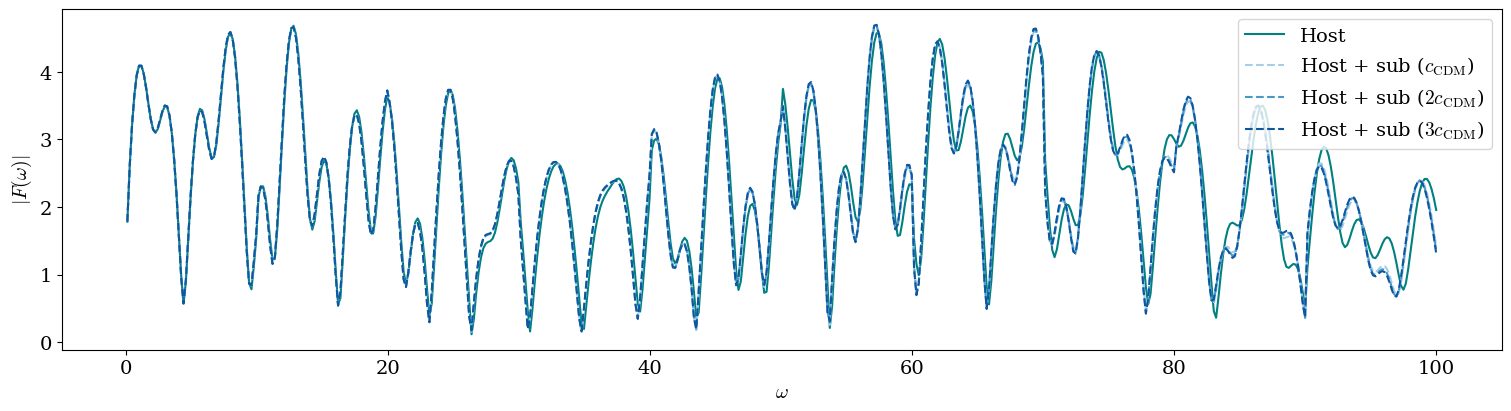

In [10]:
plot_host_vs_subhalo_Fw_overplots(
    w_grid=np.linspace(0.1, 100.0, 560),
    M200_host=1e13,
    c200_host=30.0,
    M_sub_list=(1e9,),
    sub_center=(1.0, 0.0),
)

### 8.2 Subhalo mass $M_{\rm sub} = 10^{10}\,M_\odot$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0010s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.6356s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   161.9639s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:    182.8036s
[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0010s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.6100s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   186.6544s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (n

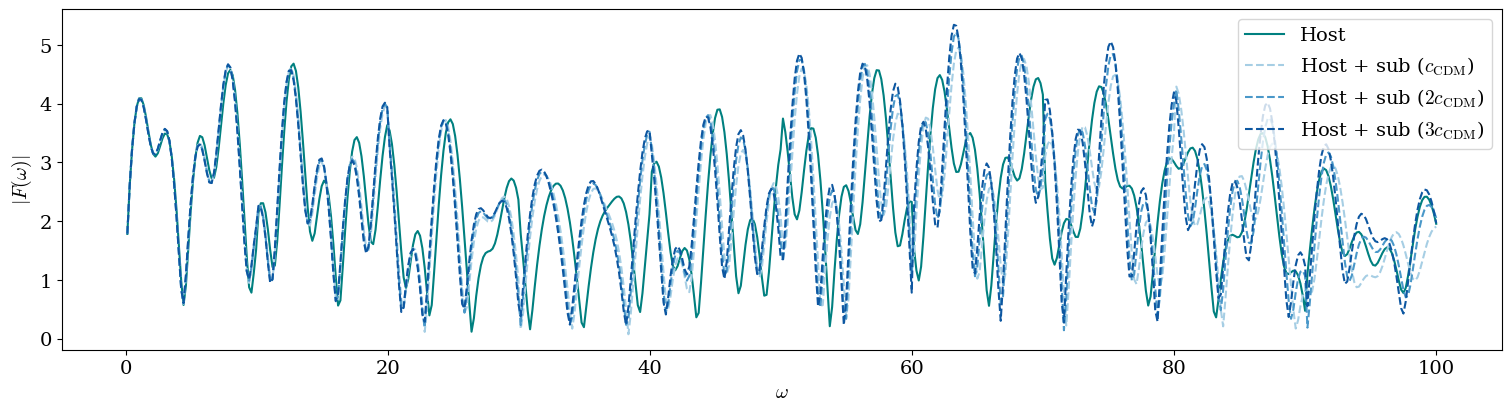

In [11]:
plot_host_vs_subhalo_Fw_overplots(
    w_grid=np.linspace(0.1, 100.0, 560),
    M200_host=1e13,
    c200_host=30.0,
    M_sub_list=(1e10,),
    sub_center=(1.0, 0.0),
)

### 8.3 Subhalo mass $M_{\rm sub} = 10^{11}\,M_\odot$

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0009s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.7457s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   149.9867s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:    170.6677s
[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0000s
  grouping:        0.0010s | groups=10
  adaptive R/h:  R in [7.07107, 70.7107] | n_gl in [1000, 10000], h in [0.0444288, 0.444288]
  quadrature:      0.7957s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:   171.1989s
  tiling:        adaptive (tiles in [1, 200], max_points=16000000)
  workers:       up to 112 (n

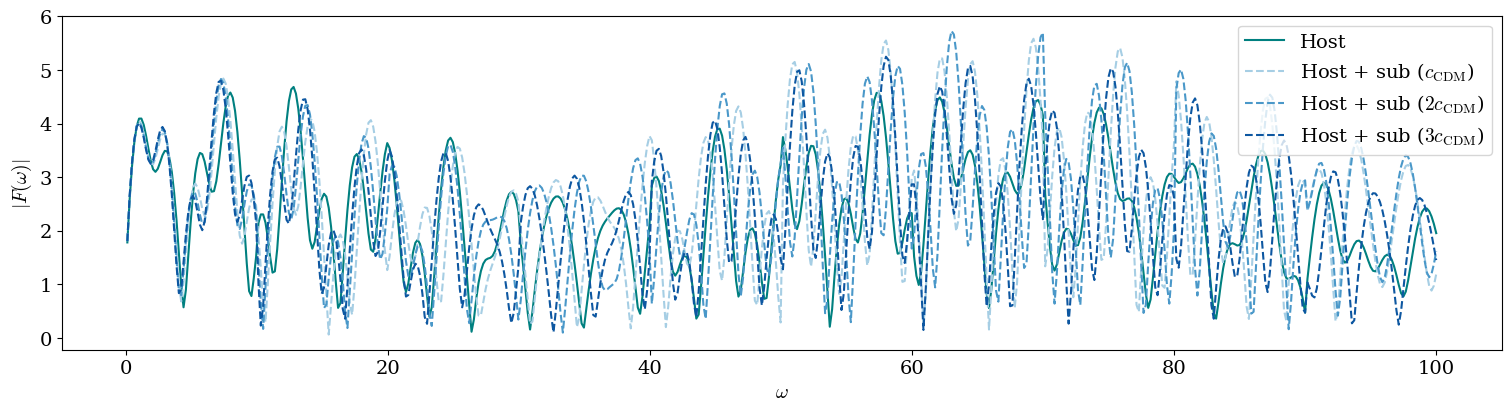

In [12]:
plot_host_vs_subhalo_Fw_overplots(
    w_grid=np.linspace(0.1, 100.0, 560),
    M200_host=1e13,
    c200_host=30.0,
    M_sub_list=(1e11,),
    sub_center=(1.0, 0.0),
)